In [ ]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from sympy import *
from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy as sc
from scipy.integrate import quad
from scipy.misc import derivative
import heapq
import math as m

In [ ]:
# Цена доставки материалов
alpha = 0.1

# Функция поверхности
def beta(x, y):
    return 1 + np.sin(5*x) * np.sin(y)

In [ ]:
def dist(x1, y1, x2, y2):
  return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [ ]:
def ifoc(x1, y1, x2, y2):
  if x2 < x1:
    x1, x2 = x2, x1
    y1, y2 = y2, y1
  len = dist(x1, y1, x2, y2)
  if x2 - x1 != 0:
    k = (y2 - y1) / (x2 - x1)
  else:
    k = 0
  x_range = np.linspace(x1, x2, 11).tolist()
  y_range = [k * x + y1 - k * x1 for x in x_range]
  sum = 0
  for i in range(10):
    sum += beta((x_range[i] + x_range[i + 1]) / 2, (y_range[i] + y_range[i + 1]) / 2)
  return (alpha / 2) * len**2 + (len / 10) * sum

In [ ]:
class Node:
    def __init__(self, x, y):
        self.x = x  # Координата x узла на карте
        self.y = y  # Координата y узла на карте
        self.g = 0  # Расстояние от начального узла до текущего узла
        self.h = 0  # Примерное расстояние от текущего узла до конечного узла
        self.f = 0  # Сумма g и h
        self.parent = None  # Родительский узел, используется для восстановления пути

    # Переопределяем оператор сравнения для сравнения узлов
    def __lt__(self, other):
        return self.f < other.f

    # Переопределяем оператор равенства для сравнения узлов
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    def __hash__(self):
        return hash((self.x, self.y))

# Определяем функцию для нахождения пути с помощью алгоритма A*
def astar(start, end, obstacles):
    # Создаем начальный и конечный узлы
    start_node = Node(start[0], start[1])
    end_node = Node(end[0], end[1])

    # Инициализируем очередь с приоритетами
    open_list = []
    heapq.heappush(open_list, start_node)

    # Инициализируем множество посещенных узлов
    closed_set = set()

    # Пока очередь с приоритетами не пуста
    while open_list:
        # Извлекаем узел с наименьшей оценкой f
        current_node = heapq.heappop(open_list)

        # Если текущий узел является конечным
        if current_node == end_node:
            # Восстанавливаем путь от конечного узла до начального
            path = []
            while current_node is not None:
                path.append((current_node.x, current_node.y))
                current_node = current_node.parent
            return path[::-1]

        # Добавляем текущий узел в множество посещенных узлов
        closed_set.add(current_node)

        # Получаем соседние узлы
        neighbors = []
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # Игнорируем текущий узел
                if dx == 0 and dy == 0:
                    continue
                # Вычисляем координаты соседнего узла
                x = current_node.x + dx
                y = current_node.y + dy
                # Игнорируем узлы за пределами карты
                if x < 0 or x >= len(obstacles) or y < 0 or y >= len(obstacles[0]):
                    continue
                # Игнорируем препятствия
                if obstacles[x][y]:
                    continue
                # Создаем новый узел и добавляем его в список соседей
                neighbor = Node(x, y)
                neighbors.append(neighbor)

        # Для каждого соседнего узла
        for neighbor in neighbors:
            # Если соседний узел уже был посещен, пропускаем его
            if neighbor in closed_set:
                continue

            # Вычисляем расстояние от начального узла до соседнего узла
            new_g = current_node.g + ifoc(current_node.x, current_node.y, neighbor.x, neighbor.y)

            # Если соседний узел уже находится в очереди с приоритетами
            if nfo := next((n for n in open_list if n == neighbor), None):
                # Если новое расстояние до соседнего узла меньше, чем старое, обновляем значения g, h и f
                if new_g < nfo.g:
                    nfo.g = new_g
                    nfo.h = m.sqrt((end_node.x - nfo.x) ** 2 + (end_node.y - nfo.y) ** 2)
                    nfo.f = nfo.g + nfo.h
                    nfo.parent = current_node
                    # Обновляем приоритет соседнего узла в очереди с приоритетами
                    heapq.heapify(open_list)
            else:
                # Иначе добавляем соседний узел в очередь с приоритетами и вычисляем значения g, h и f
                neighbor.g = new_g
                neighbor.h = m.sqrt((end_node.x - neighbor.x) ** 2 + (end_node.y - neighbor.y) ** 2)
                neighbor.f = neighbor.g + neighbor.h
                neighbor.parent = current_node
                heapq.heappush(open_list, neighbor)

    # Если конечный узел недостижим, возвращаем None
    return None

In [ ]:
grid = []
ord = 210
for row in range(ord + 1):
    grid.append([])
    for _ in range(ord + 1):
        grid[row].append(0)
start = [ord, 0]
end = [0, ord]
result = astar(start, end, grid)
for item in result:
    grid[item[0]][item[1]] += 1
coord_grid = []
for i in range(ord + 1):
    coord_grid.append([])
    for j in range(ord + 1):
        coord_grid[i].append((0 + j/ord, 1 - i/ord))
key_points_x, key_points_y = [], []
for i in range(ord + 1):
    for j in range(ord + 1):
        if grid[i][j] == 1:
            key_points_x.append(coord_grid[i][j][0])
            key_points_y.append(coord_grid[i][j][1])
key_points_x = [0] + key_points_x[::-1]
key_points_y = [0] + key_points_y[::-1]
cost = 0
for i in range(1, len(key_points_x)):
  cost += ifoc(key_points_x[i], key_points_y[i], key_points_x[i-1], key_points_y[i-1])
print(f"Стоимость строительства: {cost}")

Стоимость строительства: 1.7628928954119696


<ipython-input-141-820efbc51136>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


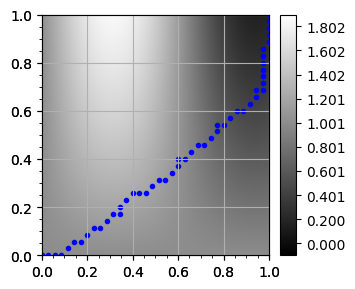

In [ ]:
def drawing_the_result(agents_x, agents_y):
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  fig, ax = plt.subplots()
  fig.set_figwidth(3)
  fig.set_figheight(3)
  ax = fig.add_subplot()
  ax.grid()
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(-0.1, 1.9, 1000), cmap="gray")
  ax.scatter(agents_x, agents_y, marker=".", color='blue')
  plt.minorticks_on()
  axins = inset_axes(ax,
                   width="7%",
                   height="100%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
  plt.colorbar(im, cax=axins)
  plt.tight_layout()
  plt.show()

drawing_the_result(key_points_x, key_points_y)